In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time 
from time import time
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation

In [3]:
dataset = pd.read_csv('dataset_normalizado.csv')
imputpd, preciopd = dataset[[i for i in dataset.columns if i!="Unnamed: 0" and i!='Close']], dataset['Close']

In [4]:
imput = imputpd.to_numpy()
precio = preciopd.to_numpy()

In [5]:
def getModel():
    model = Sequential()
    model.add(Dense(4, input_shape=(4,)))
    model.add(Activation('relu'))
    model.add(Dense(9, input_shape=(4,)))
    model.add(Activation('relu'))
    model.add(Dense(3, input_shape=(9,)))
    model.add(Activation('sigmoid'))
    
    model.compile(loss = 'mse', optimizer = 'adam', metrics=['accuracy'] )
    return model
    
def save_pool():
    for xi in range(total_models):
        current_pool[xi].save_weights("SavedModels/model_new" + str(xi) + ".keras")
    print("Saved current pool!")

def predict_action(EntradasDelModelo, model_num):
    global current_pool
    # se normalizan las entradas del modelo
    
    neural_input = EntradasDelModelo
    output_prob = current_pool[model_num].predict(neural_input,batch_size=400)
    accion = np.argmax(output_prob,axis =1)
    
    return accion

def model_crossover(parent1, parent2):
    # obtain parent weights
    # get random gene
    # swap genes
    global current_pool

    weight1 = current_pool[parent1].get_weights()
    weight2 = current_pool[parent2].get_weights()

    new_weight1 = weight1
    new_weight2 = weight2

    gene = random.randint(0,len(new_weight1)-1)

    new_weight1[gene] = weight2[gene]
    new_weight2[gene] = weight1[gene]

    return np.asarray([new_weight1,new_weight2])

def model_mutate(weights):#,generation):
    
    # mutate each models weights
    for i in range(len(weights)):
        for j in range(len(weights[i])):
            if( random.uniform(0,1) > 1-mutation_rate):
                change = random.uniform(-0.5,0.5)
                weights[i][j] += change
    return weights

def ejecutar_accion(accion,price,model_num):
    
    #0  es mantenerse
    #1  es comprar
    #2  es vender

    if(accion == 0):
        return
    elif(accion == 1):
        if wallet[model_num] < price:
            return
        wallet[model_num] = wallet[model_num]-price
        portafolio[model_num] = portafolio[model_num] + 1 
    else:
        if portafolio[model_num] == 0:
            return
        portafolio[model_num] = portafolio[model_num] - 1
        wallet[model_num] = wallet[model_num] + price          
    return

In [6]:
load_saved_pool = False
save_current_pool = True
total_models = 50
mutation_rate = 0.15
wallet_inicial = 1000

In [7]:
current_pool = []
fitness = []
wallet = []
portafolio = []
historicoW = []
historicoP = []

for i in range(total_models):
    current_pool.append(getModel())
    wallet.append(wallet_inicial)
    fitness.append(0)
    portafolio.append(0)
    historicoW.append([])
    historicoP.append([])

In [8]:
for k in range(100):
    #--------------------------------- simulamos 400 dias en el mercado en un punto aleatorio del dataset ----------
    momento = random.randint(0,5500)
    ejecucion = time()

    for i in range(total_models):
        actions = predict_action(imput[momento:momento+400],i)
        for j in range(momento , momento+400):
            ejecutar_accion(actions[j-momento],precio[j],i)
            historicoW[i].append(wallet[i])  
            historicoP[i].append(portafolio[i])


    #-------------------------------- evaluamos a los modelos -------------------------------------------        

    for i in range(total_models):

        total_activos = wallet[i]+(portafolio[i]*(precio[momento+400]*0.7))

        if total_activos != wallet_inicial:
            fitness[i] = total_activos
        else:
            fitness[i] =  0

    mejores = np.argsort(fitness)
#     print(mejores[-1])
#     print(wallet[mejores[-1]]+(portafolio[mejores[-1]]*(precio[momento+400])))
#     print(mejores[-2])
#     print(wallet[mejores[-2]]+(portafolio[mejores[-2]]*(precio[momento+400])))

    print('generacion:'+str(k))
    print('dinero: '+str(wallet[mejores[-1]]+(portafolio[mejores[-1]]*(precio[momento+400]))))
    #------------------------------- los 2 mejores se reproducen y crean la nueva generacion ---------------


    for k in range(0,total_models,2):
        pesos = model_crossover(mejores[-1], mejores[-2])

        pesos1 = pesos[0]
        pesos2 = pesos[1]

        pesos1 = model_mutate(pesos1)
        pesos2 = model_mutate(pesos2)
        
        if k == 0:
            current_pool[k].set_weights(current_pool[mejores[-1]].get_weights())
            current_pool[k+1].set_weights(current_pool[mejores[-2]].get_weights())

        current_pool[k].set_weights(pesos1)
        current_pool[k+1].set_weights(pesos2)

    #--------------------------------------imprimo los historicos----------------------------------------------
#     historicoWCopy = np.array(historicoW)
#     historicoPCopy = np.array(historicoP)
    
#     preciopd[momento:momento+400].plot(figsize=(15,3))
#     plt.show()
#     plt.plot(historicoWCopy.T)
#     plt.legend(('bot 0', 'bot 1', 'bot 2', 'bot 3', 'bot 4', 'bot 5','bot 6', 'bot 7', 'bot 8', 'bot 9'))
#     plt.show()
#     plt.plot(historicoPCopy.T)
#     plt.legend(('bot 0', 'bot 1', 'bot 2', 'bot 3', 'bot 4', 'bot 5','bot 6', 'bot 7', 'bot 8', 'bot 9'))
#     plt.show()

    #------------------------------------- reinicio wallets y demas --------------------------------------------
    a = historicoW
    b = historicoP
    historicoW = []
    historicoP = []
    for i in range(total_models):    
        wallet[i]=wallet_inicial 
        fitness[i] = 0
        portafolio[i] = 0
        historicoW.append([])
        historicoP.append([])


    ejecucion = time()-ejecucion
    print('tiempo: '+str(ejecucion))


generacion:0
dinero: 1037.330011
tiempo: 12.070404052734375
generacion:1
dinero: 1008.2799989999997
tiempo: 4.966013669967651
generacion:2
dinero: 1011.729999
tiempo: 4.7922868728637695
generacion:3
dinero: 999.8199979999999
tiempo: 4.520012617111206
generacion:4
dinero: 999.58
tiempo: 5.181589603424072
generacion:5
dinero: 1014.2699990000001
tiempo: 5.42750883102417
generacion:6
dinero: 1019.3300090000006
tiempo: 4.3307459354400635
generacion:7
dinero: 1022.5900029999997
tiempo: 4.650146722793579
generacion:8
dinero: 1008.054374
tiempo: 4.502048969268799
generacion:9
dinero: 1080.2600140000002
tiempo: 5.409041881561279
generacion:10
dinero: 999.16
tiempo: 5.073969125747681
generacion:11
dinero: 1000.04
tiempo: 4.66003155708313
generacion:12
dinero: 1006.3799949999998
tiempo: 4.855032920837402
generacion:13
dinero: 1000.220001
tiempo: 4.982846736907959
generacion:14
dinero: 1007.4000060000001
tiempo: 5.28583836555481
generacion:15
dinero: 999.8
tiempo: 4.660969018936157
generacion:16
d

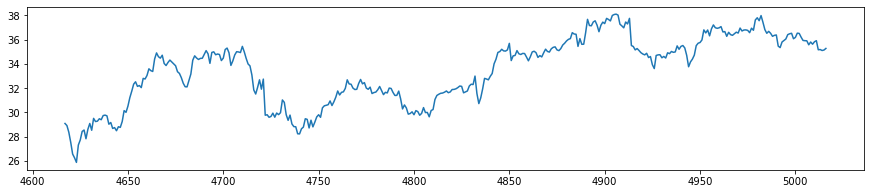

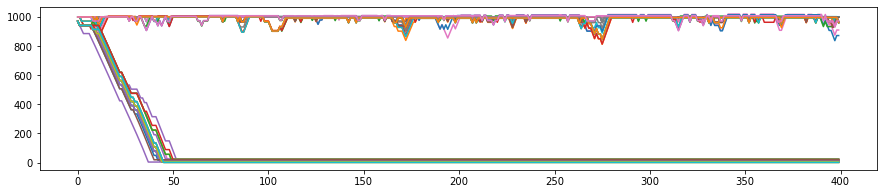

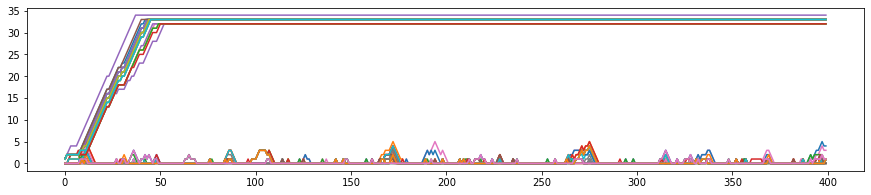

In [9]:
historicoWCopy = np.array(a)
historicoPCopy = np.array(b)

preciopd[momento:momento+400].plot(figsize=(15,3))
plt.show()
plt.figure(figsize=(15,3))
plt.plot(historicoWCopy.T)
plt.show()
plt.figure(figsize=(15,3))
plt.plot(historicoPCopy.T)
plt.show()

In [70]:
save_pool()

Saved current pool!
